In [40]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()
from pprint import pprint

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
# Reading data
data = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
data

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0


* Data has 660 rows and 7 columns

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


* There is a wide spread of values between the features - min/ max for credit limit is 3k/200k
    *  for visits to bank min/ max is 0 / 5
* Will need to scale data using zscore 

In [5]:
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

* Sl_No has as many uniques as dataset so can be dropped
* Customer Key seems to have a few multiple entries for some customer keys - will need to investigate
* Credit Limit has a wide spread of values
* the others are more like categorical features - total credit cards, total visits, online visits and calls
    * Very few unique values 

In [38]:
# fixing column names to avoid spaces
data.columns = [c.replace(' ','_') for c in data.columns]

In [43]:
#which customer keys are repeated
x=data.Customer_Key.value_counts()
x=x[x>1]
y=x.index.tolist()
print('Customer Keys which have multiple entries in dataset are:')
pprint(y)

Customer Keys which have multiple entries in dataset are:
[50706, 37252, 97935, 96929, 47437]


In [33]:
#examining rows in data where customer key is same
for c in y:
    display(data[data.Customer_Key==c])

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


In [49]:
working_df = data.iloc[:,2:] #defining working_df and not including sl_no and customer key as they dont add to our analysis

In [50]:
working_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3
...,...,...,...,...,...
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0


## Univariate Analysis

In [74]:
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(feature, kde=False, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.histplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

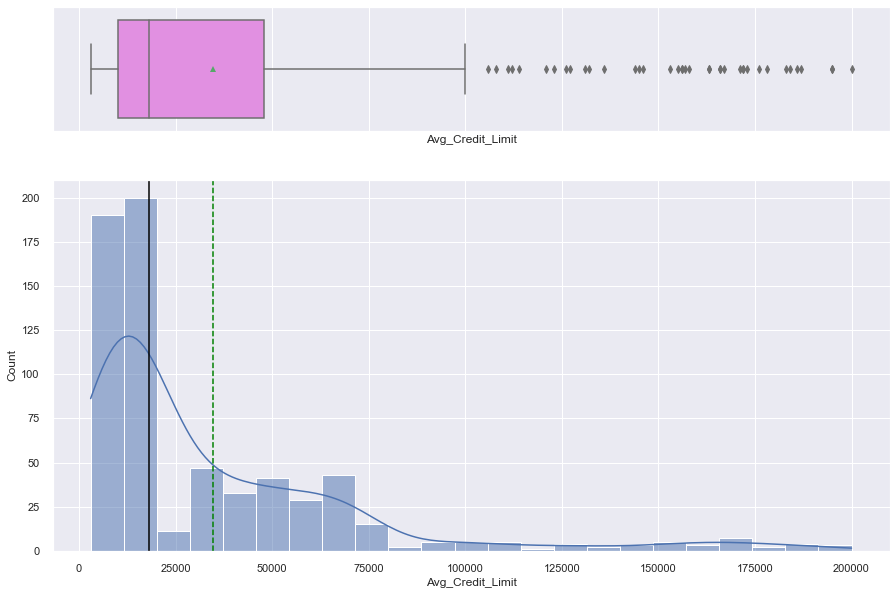

In [67]:
histogram_boxplot(working_df['Avg_Credit_Limit'])

* Avg_Credit_Limit is right skewed
    * mean is ~35000 and median is 18000 (from description used earlier)
* The boxplot upper fence is at 100,000 and there are a number of outliers beyond that too

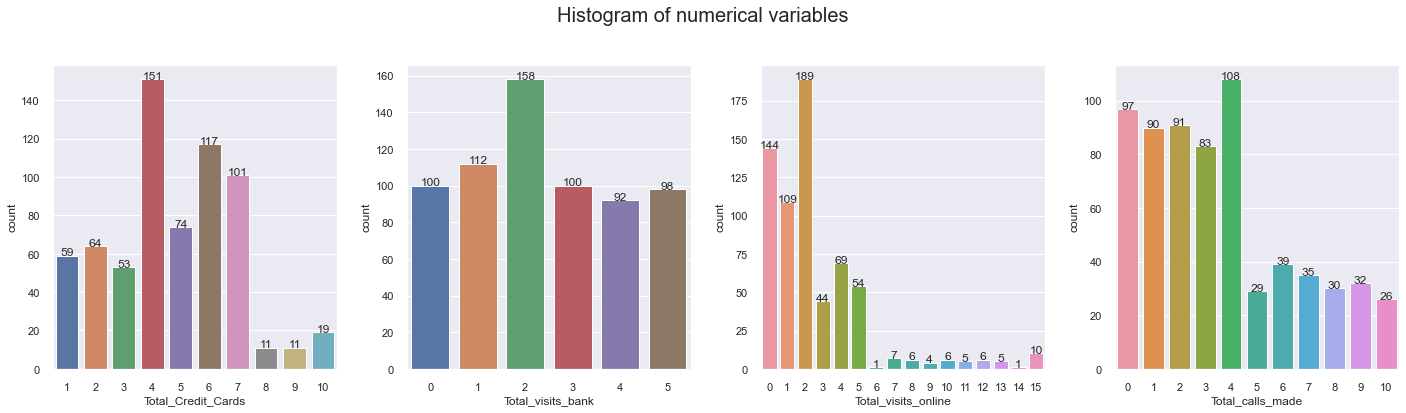

In [68]:
all_col = working_df.iloc[:,1:].columns
fig, axes = plt.subplots(1, 4,  figsize=(20, 6))
fig.suptitle('Histogram of numerical variables', fontsize=20)
counter = 0
for ii in range(4):
    zz=sns.countplot(ax=axes[ii],x=working_df[all_col[counter]])
    show_values_on_bars(zz)
    counter = counter+1

fig.tight_layout(pad=2.0)

* Total_Credit_Cards: 
    * About 25% of the data set have 4 credit cards, followed by 6 and 7 cards with 117 and 101 people
    * Very few customers own 8 or more cards
* Total_visits_bank
    * 158 customers have visited the bank 2 ties 
    * Symmetric distribution
* Total_visits_online
    * 189 customers have visited the bank online site 2 times followed by 144 who have not visited the bank at all
    * While few customers have visited online > 5 times, there is a slight uptick at 15 - will see if data points at why
* Total_calls_made
    * 108 customers have called the bank 4 times

## Bivariate Analysis

<AxesSubplot:>

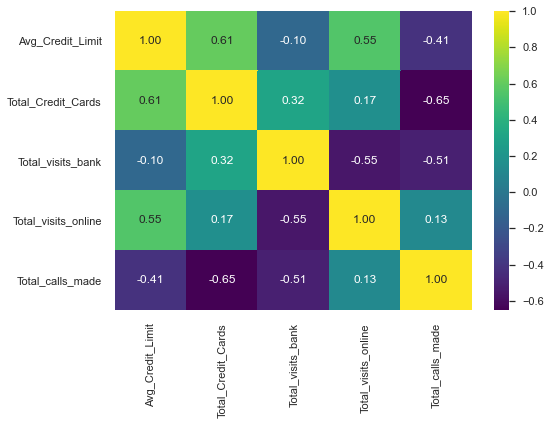

In [71]:
sns.heatmap(working_df.corr(), annot=True, fmt='.2f', cmap='viridis')

* brilliant insights here


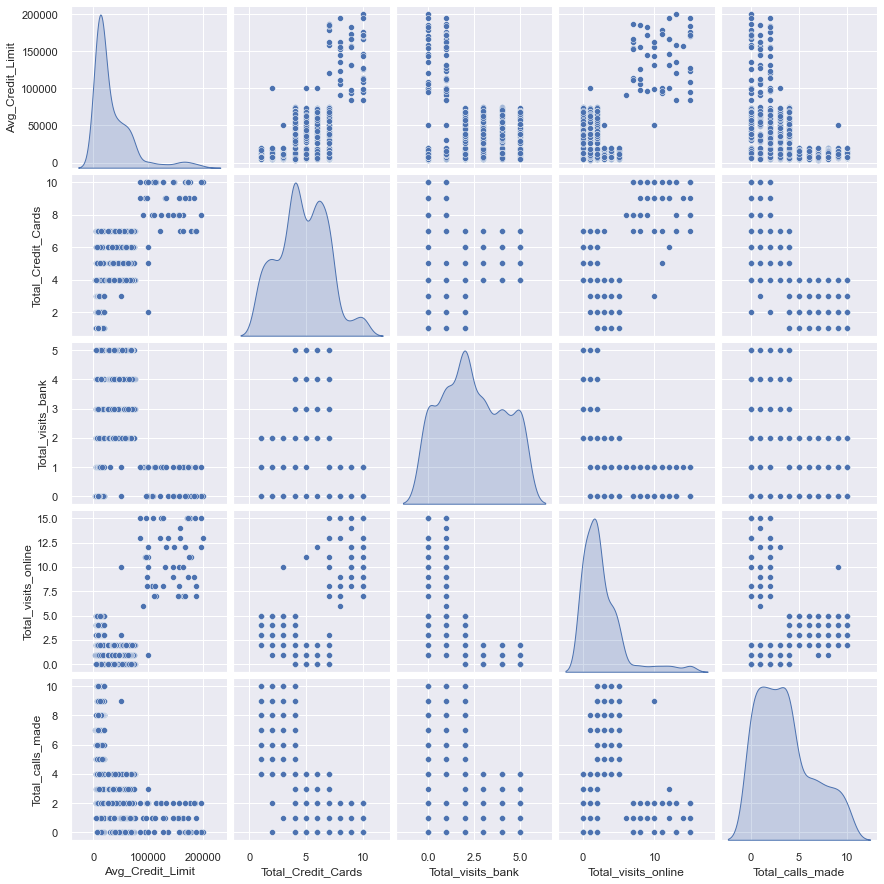

In [73]:
sns.pairplot(working_df, diag_kind='kde')

* more brilliant insghts


## Modelling 

In [78]:
# Scaling the data set before clustering
scaler=StandardScaler()
#wo=working_df.copy()
scaled_data=scaler.fit_transform(working_df)

In [80]:
df_scaled = pd.DataFrame(scaled_data, columns = working_df.columns)
df_scaled

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739
...,...,...,...,...,...
655,1.713589,2.443892,-0.860451,2.520519,-1.251537
656,1.314621,2.443892,-0.860451,3.543188,-0.553005
657,2.937092,1.520613,-0.860451,2.179629,-0.902271
658,3.655235,2.443892,-0.860451,4.224968,-1.251537


In [81]:
df_scaled.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02
mean,8.612639e-17,4.306320e-17,-4.306320e-17,7.536059e-17,-8.612639e-17
std,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00
min,-8.398081e-01,-1.710864e+00,-1.473731e+00,-8.883795e-01,-1.251537e+00
25%,-6.536229e-01,-7.875852e-01,-8.604506e-01,-5.474897e-01,-9.022711e-01
50%,-4.408398e-01,1.356941e-01,-2.471705e-01,-2.065999e-01,-2.037386e-01
75%,3.570968e-01,5.973337e-01,9.793898e-01,4.751797e-01,4.947938e-01
max,4.399975e+00,2.443892e+00,1.592670e+00,4.224968e+00,2.241125e+00


Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9566134352172467
Number of Clusters: 7 	Average Distortion: 0.9095661498049182
Number of Clusters: 8 	Average Distortion: 0.8907499879985157


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

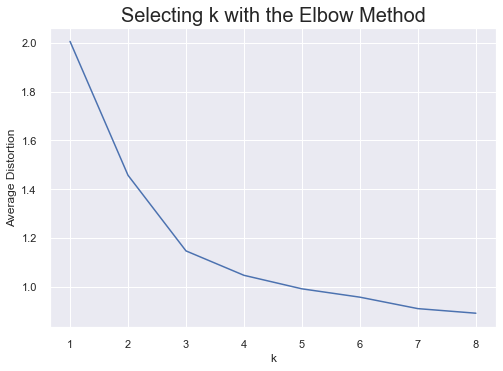

In [84]:
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df_scaled)
    prediction=model.predict(df_scaled)
    distortion=sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)

In [87]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((df_scaled))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41842496663215445)
For n_clusters = 3, silhouette score is 0.5157182558881063)
For n_clusters = 4, silhouette score is 0.3556670619372605)
For n_clusters = 5, silhouette score is 0.2717470361089752)
For n_clusters = 6, silhouette score is 0.24357816716616515)
For n_clusters = 7, silhouette score is 0.24856151430206486)
For n_clusters = 8, silhouette score is 0.22709043786510935)
For n_clusters = 9, silhouette score is 0.2188545597025186)


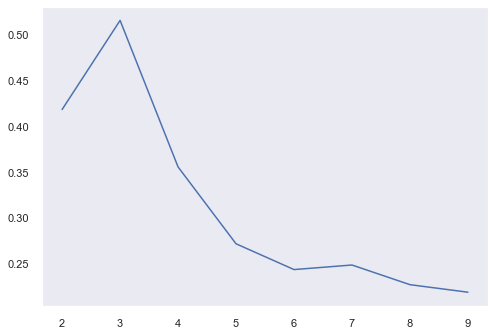

In [88]:
plt.plot(cluster_list,sil_score)
plt.grid()

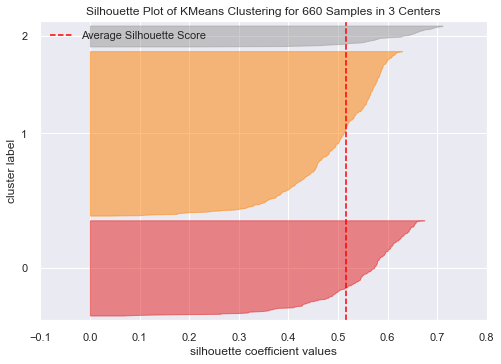

In [89]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(df_scaled)    
visualizer.show();

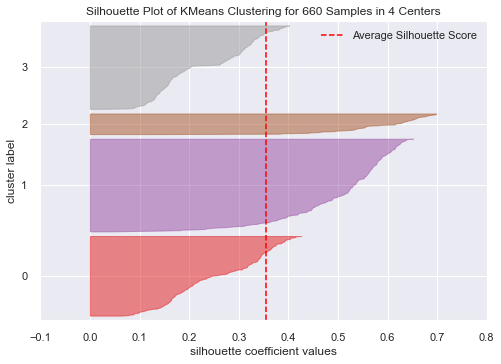

In [90]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(df_scaled)    
visualizer.show();

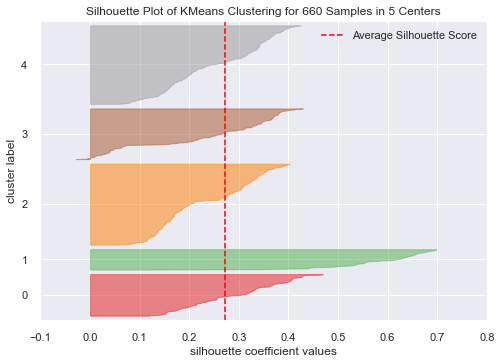

In [91]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(df_scaled)    
visualizer.show();

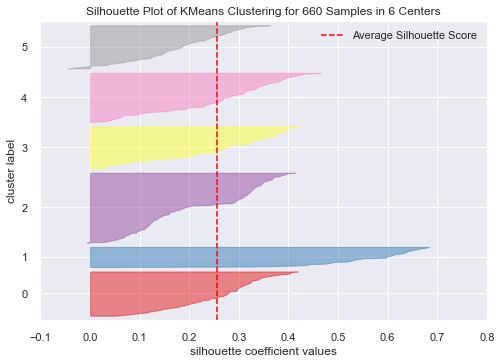

In [92]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state = 1))
visualizer.fit(df_scaled)    
visualizer.show();